<h1>Cegpy</h1>

<h2>Example 1: Chain Event Graph From Rectangular Dataset</h2>

This first example builds a Chain Event Graph (CEG) from a dataset showing results from a medical experiment.
The dataset used is symetrical, built from a rectangular dataset. These CEGs are known as <em>stratified</em> in the literature.


1. We build an Event Tree. This allows us to establish all the possible paths that were taken through the process. 
2. Staged Tree is created, where an Agglomerative Hierarchical Clustering (AHC) algorithm is applied to it, to establish which nodes in the EventTree share similar statistical properties.
3. The Staged Tree is then processed into a CEG.
4. The CEG is minised further given observed evidence. 



<h3>Step 1: Importing dataset</h3>

The example 'medical.xlsx' dataset contains 4 variables; Classification, Group, Difficulty, Response.
Each individual is given a classification; blast or non-blast. Each group is rated on their experience level; experienced, inexperienced, or novice.
The classification task they are given has a difficulty rating of easy or hard. Finally, their response is shown; blast or non-blast.

The table looks like so:

| Classification | Group         | Difficulty | Response  |
| -------------- | ------------- | ---------- | --------- |
| Blast          | Experienced   | Easy       | Blast     |
| Non-blast      | Inexperienced | Hard       | Non-blast |
| Blast          | Novice        | Easy       | Non-blast |
| ...            | ...           | ...        | ...       |

In [1]:
import pandas as pd
df = pd.read_excel("medical.xlsx")

<h3>Step 2: Creation of the Event Tree of the Dataset </h3>

Event Tree class is passed the pandas dataframe.

If you aren't interested in the event tree, skip this step.


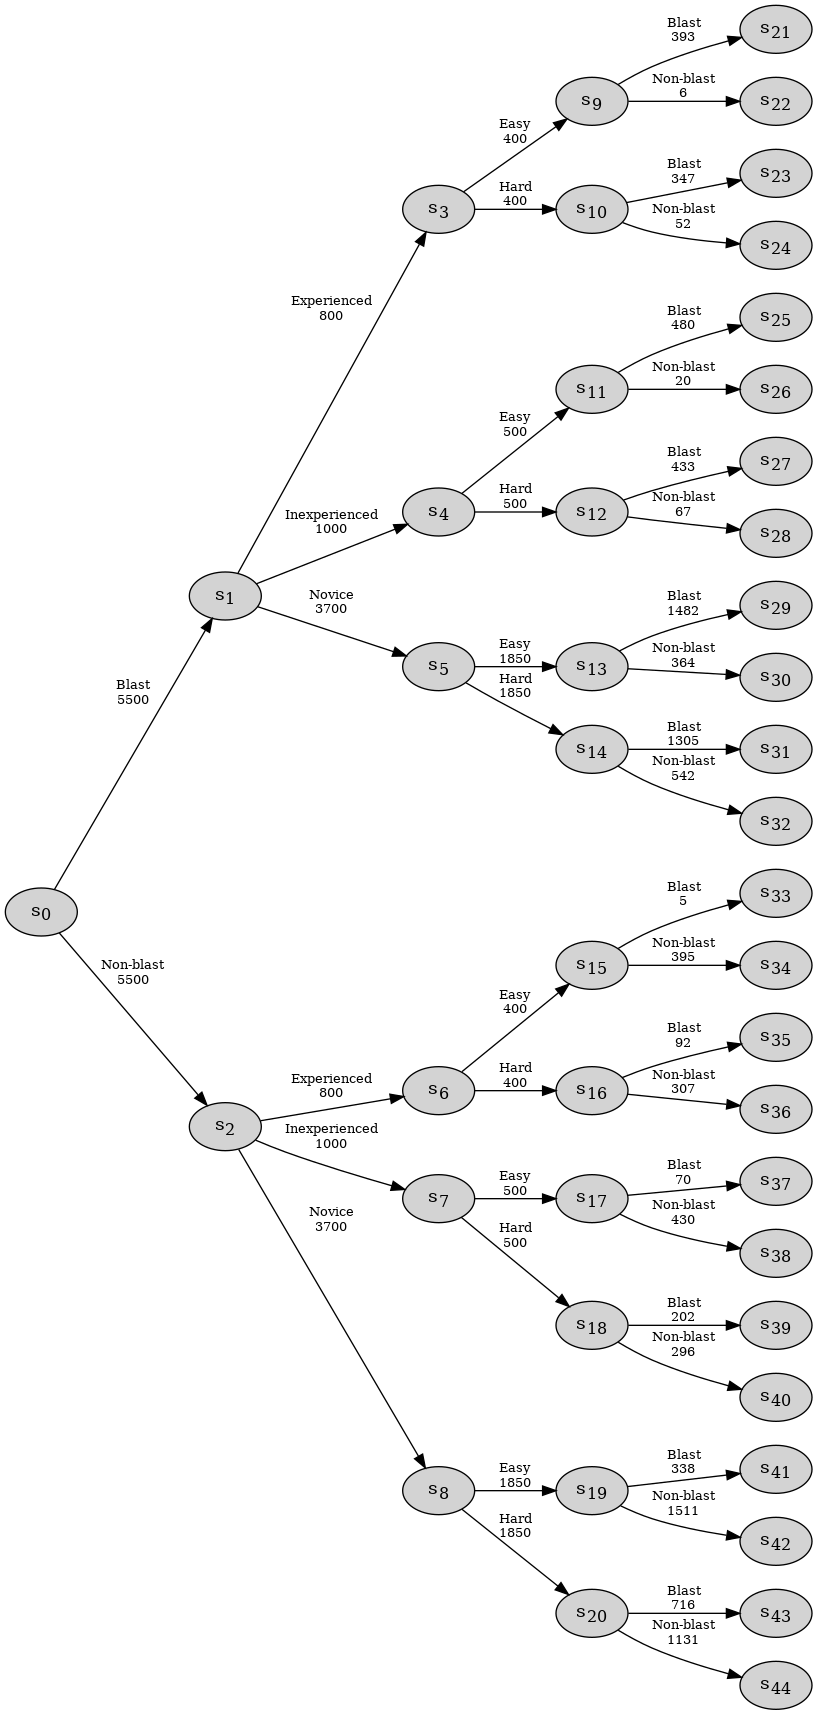

In [2]:
from cegpy import EventTree

et = EventTree(df)
et.create_figure('output/medical_event_tree.pdf')

<h3>Step 3: Creation of the Staged Tree</h3>

The Staged Tree object inherits the Event Tree object, so this can be called directly.
AHC is executed on the tree, and the nodes are assigned a colour if they are found to be in the same 'stage' as each other.
Effectively, we can consider these nodes as equivalent to each other, which allows us to compress the tree into a chain event graph.

The creation of the figure is shown to demonstrate the output of this class, however if you are not interested in seeing it, simple create the staged tree and calculate AHC transitions.

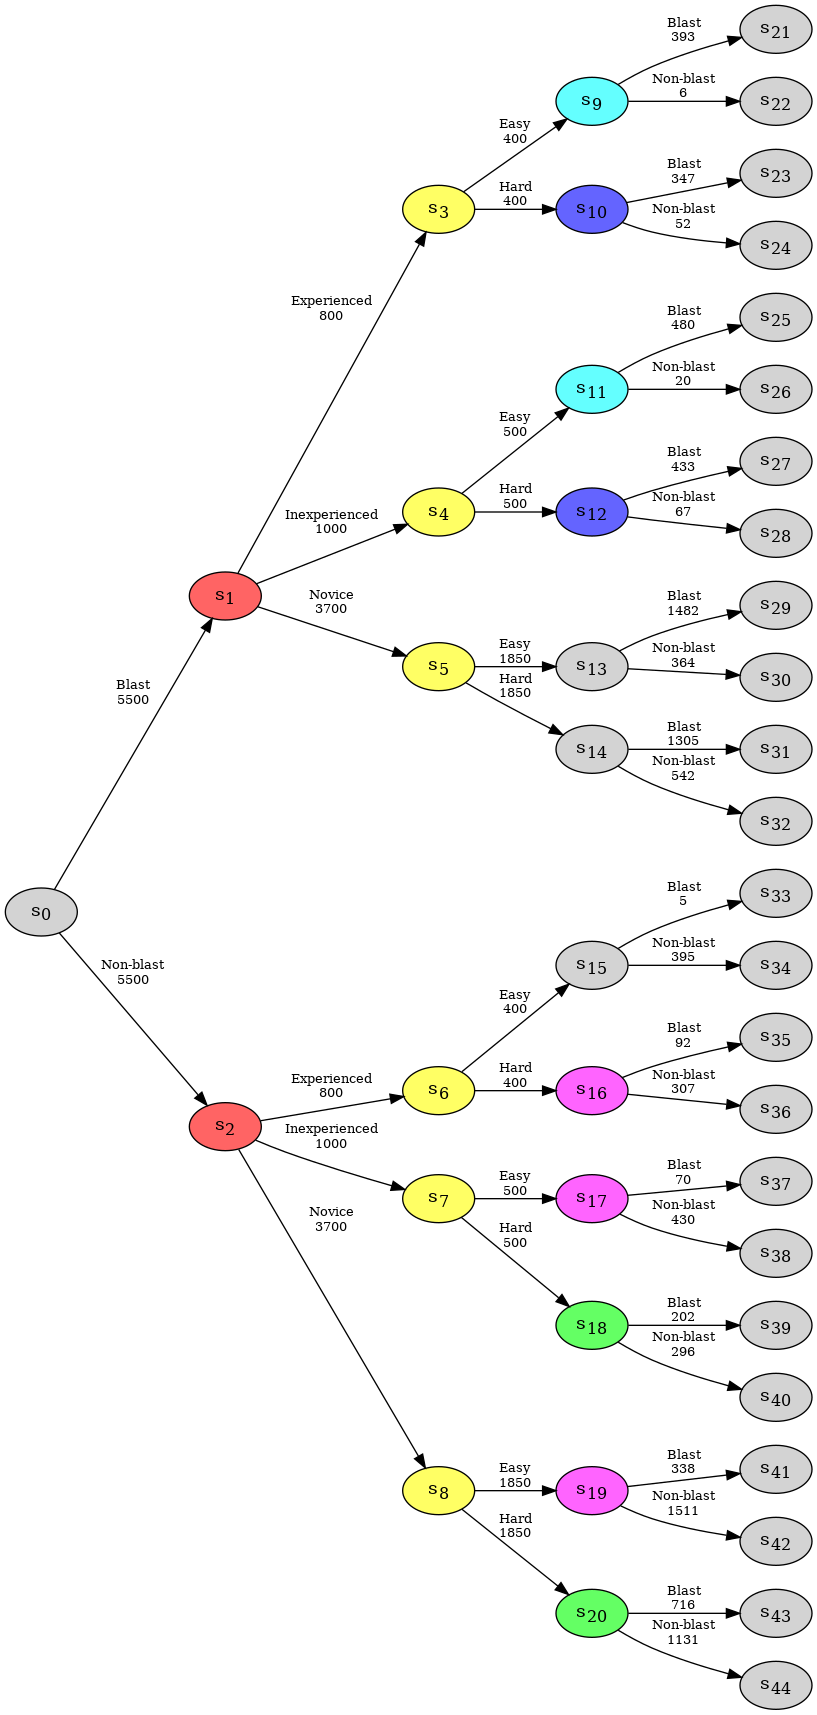

In [3]:
from cegpy import StagedTree

st = StagedTree(df)
st.calculate_AHC_transitions()

# figure is created, any filetype that graphviz supports can be used.
st.create_figure('output/medical_staged_tree.svg')

<h3>Step 4: Creation of the Chain Event Graph</h3>

Pass the staged tree into the chain event graph class, and call the generate function to transform the tree into a CEG.
Nodes in the same stage are compared to determine if it is possible to join them together or not. Some are simply not logically compatible with each other.

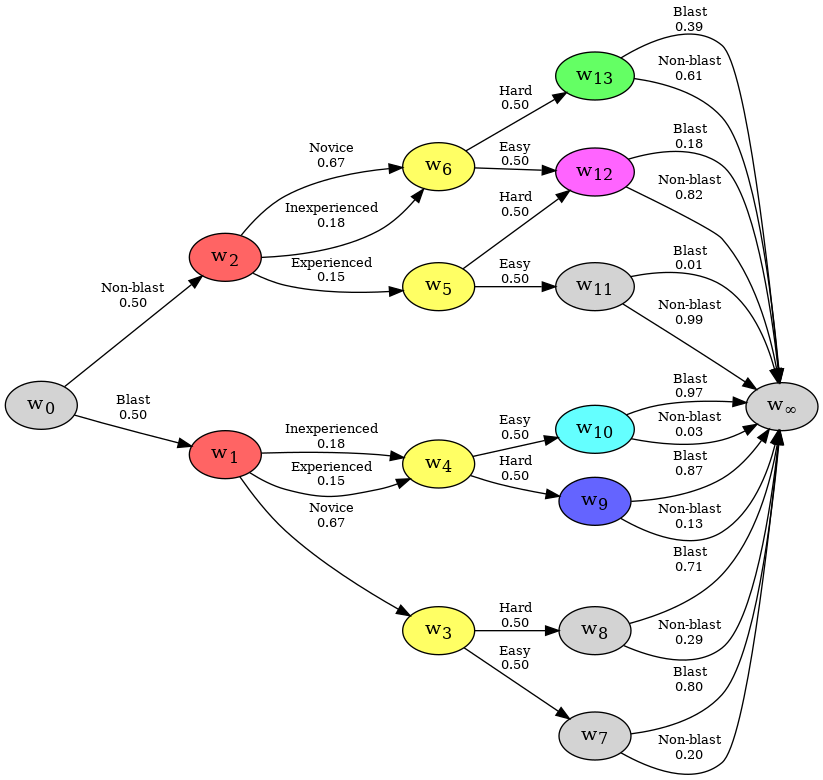

In [4]:
from cegpy import ChainEventGraph, Util

ceg = ChainEventGraph(st)
ceg.generate()

ceg.create_figure('output/medical_CEG.pdf')

<h3>Step 5: Minimising the CEG given observed evidence</h3>

Now you have a CEG model of the process, you can start to query it with evidence, and reduce the graph to take that evidence into account. 

If you are certain that a node or an edge in the graph was traversed, you can add that as certain evidence. 
For example if you know that the participant was assigned Non-Blast, and is a Novice, you add the edge 'w2' -> 'w6' with label 'Novice', and mark it as certain.

``` python
# Using the Evidence.CERTAIN object
>>> ceg.evidence.add_edge('w2', 'w6', 'Novice', Evidence.CERTAIN)

# Alternatively, certain can = True or False
>>> ceg.evidence.add_edge('w2', 'w6', 'Novice', True)
```

In [5]:
from cegpy import Evidence
ceg.evidence.add_edge('w2', 'w6', 'Novice', Evidence.CERTAIN)

The effect of this can be seen by creating a graph from the <em>reduced_graph</em> property of the CEG. 

The evidence is propagated through the graph to revise the probabilites of each edge.

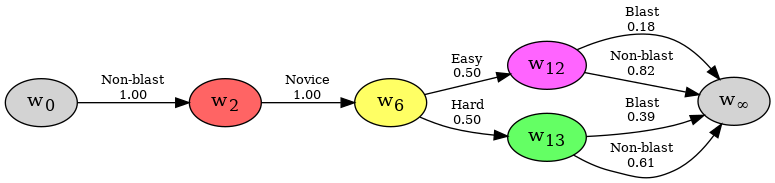

In [6]:
ceg.evidence.reduced_graph.create_figure('output/medical_certain_novice.pdf')

If you weren't sure which of two edge's were traversed, you can add both as <em>uncertain</em> evidence.
For example, say you only knew that the participant was either experienced or inexperienced. You could add the evidence as follows:

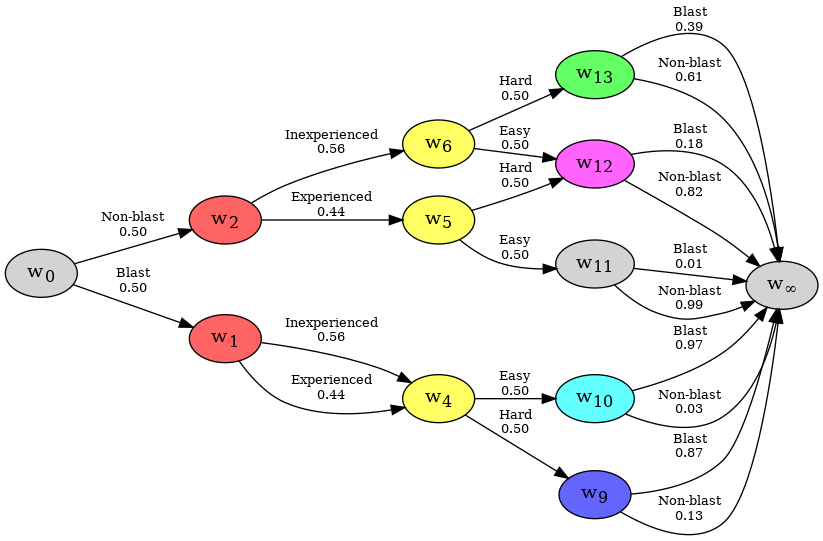

In [7]:

# First, clear evidence we added previously, to allow us to add new evidence.
ceg.clear_evidence()

# For the "Blast" participants, we can add an uncertain node:
ceg.evidence.add_node('w4', Evidence.UNCERTAIN)
# For the "Non-blast" participants, we can add a list of uncertain edges.
non_blast_edges = [
    ('w2', 'w5', 'Experienced'),
    ('w2', 'w6', 'Inexperienced')
]
ceg.evidence.add_edges_from(non_blast_edges, Evidence.UNCERTAIN)
ceg.evidence.reduced_graph.create_figure('output/medical_uncertain.pdf')


<h2>Example 2: Chain Event Graph From Non-Stratified Dataset</h2>

This example builds a Chain Event Graph (CEG) from a dataset which shows the progression .
The dataset used is un-symmetrical, built from a dataset where some variables are missing for certain rows. These CEGs are known as <em>non-stratified</em> in the literature. In the event tree below, paths such as S<SUB>0</SUB> -> S<SUB>2</SUB> -> S<SUB>7</SUB> -> S<SUB>18</SUB> skip a variable, as no data for that variable was given.


Dataset is imported, and event tree is created.

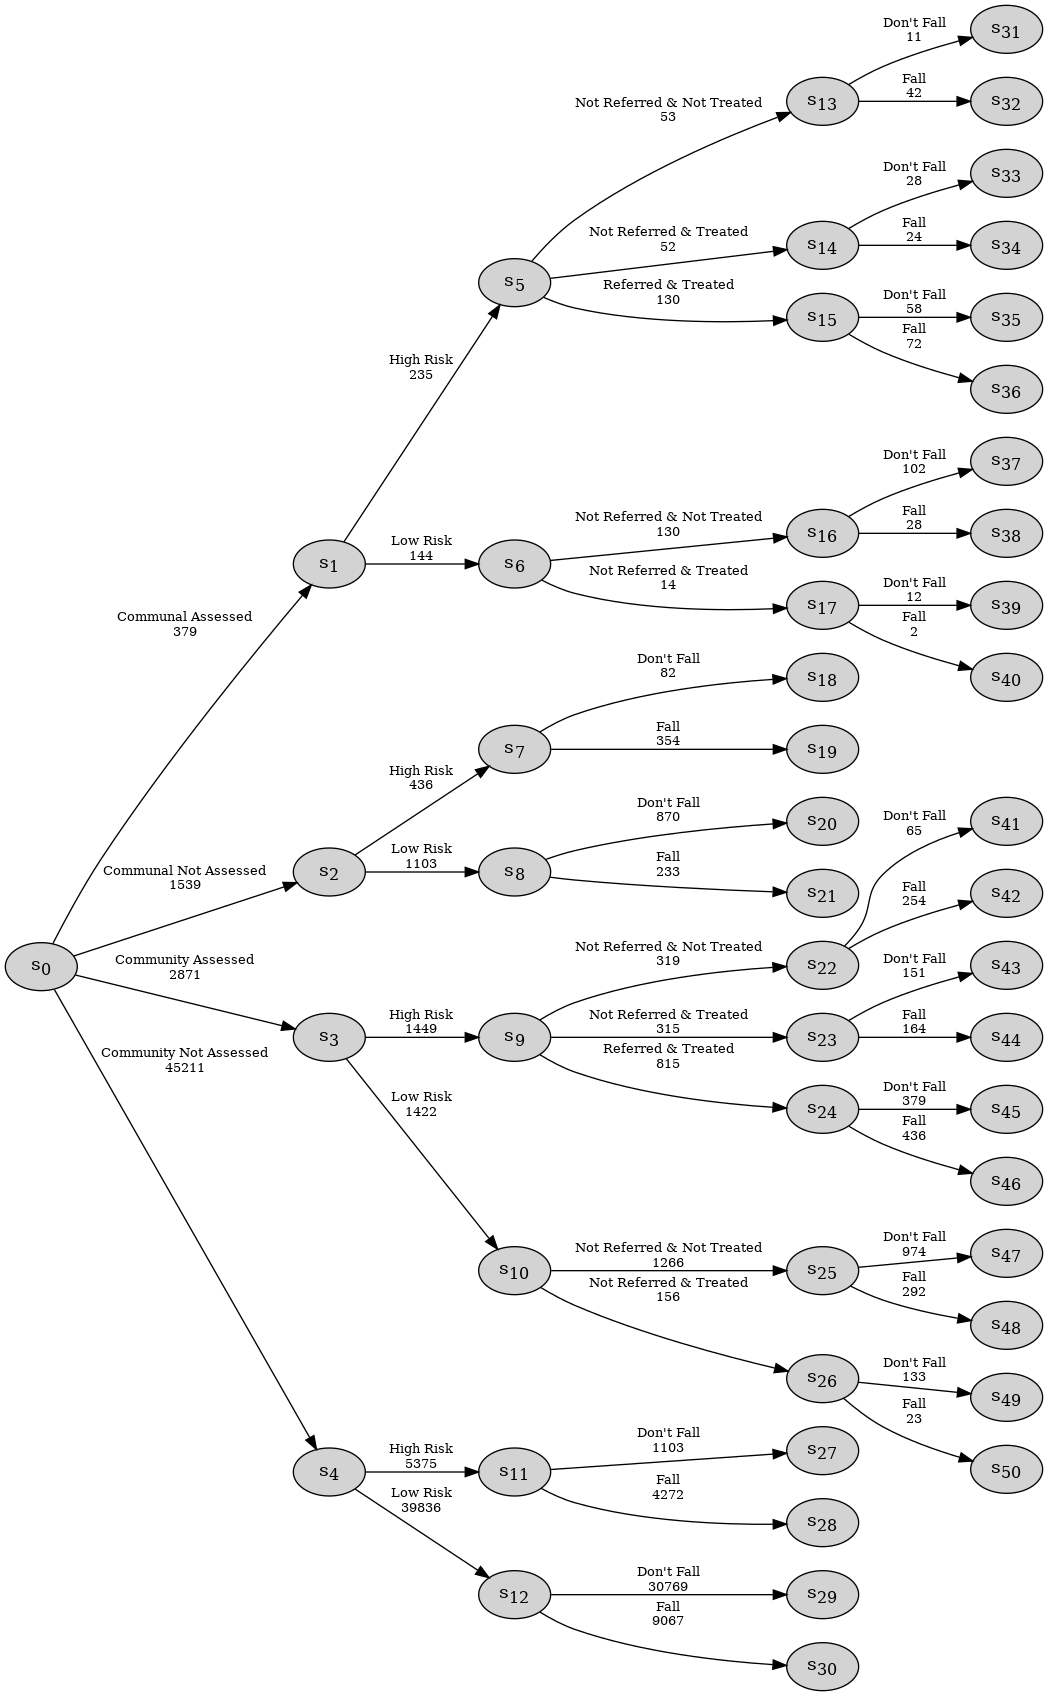

In [8]:
from cegpy import EventTree
import pandas as pd

df = pd.read_excel('falls.xlsx')
et = EventTree(df)
et.create_figure('output/et_falls.pdf')

<h3>Staged Tree </h3>

As before, the AHC algorithm marks the nodes that could possibly be merged. 

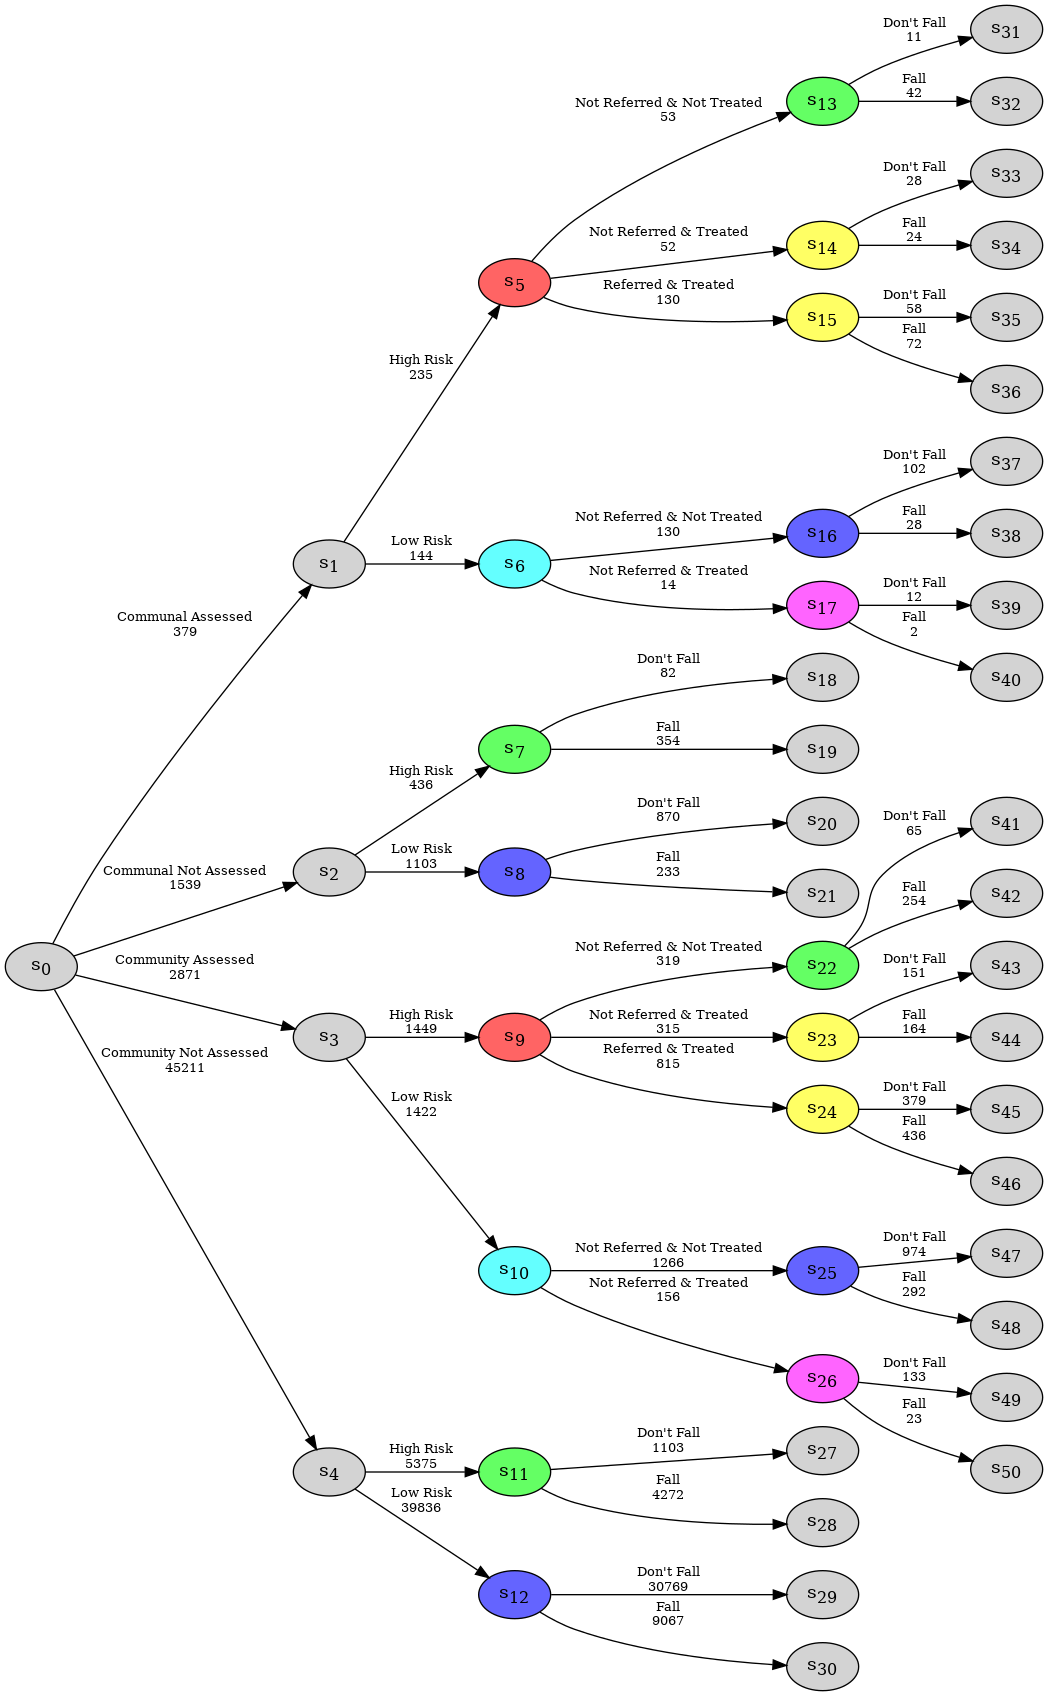

In [9]:
from cegpy import StagedTree
import pandas as pd

df = pd.read_excel('falls.xlsx')
st = StagedTree(df)
st.calculate_AHC_transitions()
st.create_figure('output/st_falls.pdf')


<h3>Chain Event Graph</h3>

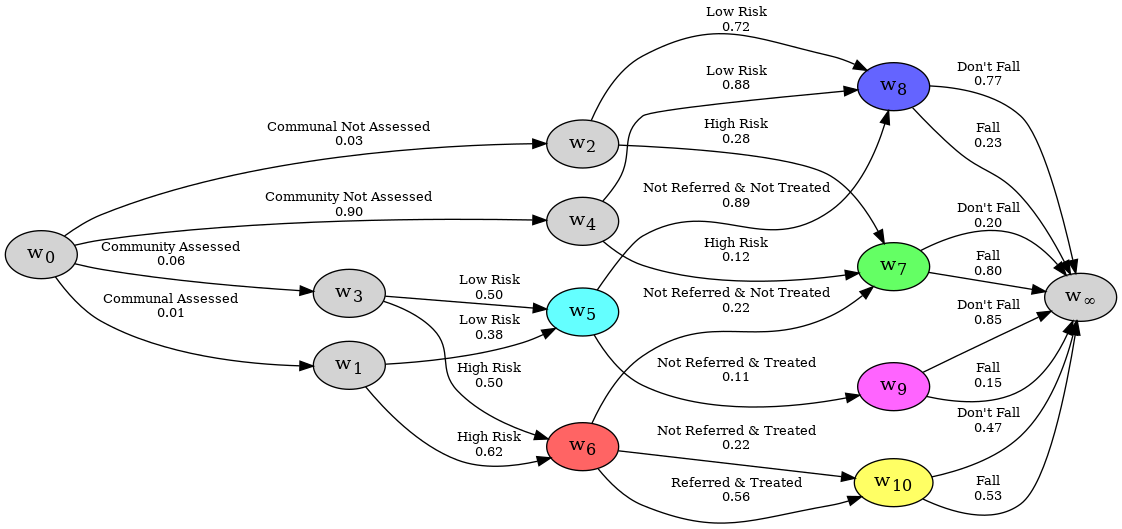

In [10]:
from cegpy import ChainEventGraph

ceg = ChainEventGraph(st)
ceg.generate()
ceg.create_figure('output/ceg_falls.pdf')

<h3>Minimising the CEG given observed evidence</h3>

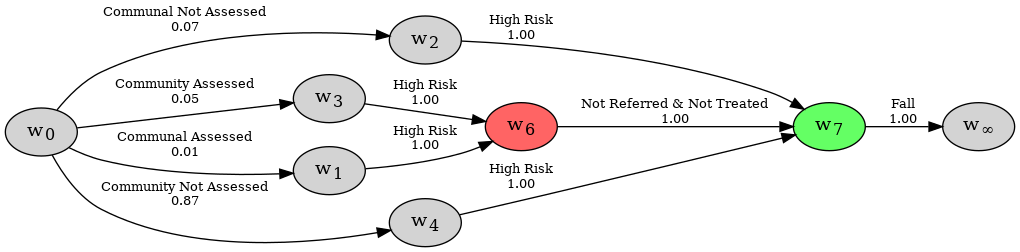

In [11]:
from cegpy import Evidence as ev

ceg.evidence.add_edge('w7', ceg.sink_node, 'Fall', ev.CERTAIN)
ceg.evidence.reduced_graph.create_figure('output/falls_certain.pdf')

Assume that we know the population that we are interested in are Assessed either in the community or communal. We can enter this informaion as follows

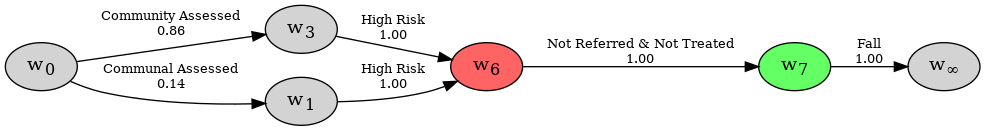

In [12]:
from cegpy import Evidence as ev

ceg.clear_evidence()
ceg.evidence.add_node('w1', ev.UNCERTAIN)
ceg.evidence.add_node('w3', ev.UNCERTAIN)
ceg.evidence.add_edge('w7', ceg.sink_node, 'Fall', ev.CERTAIN)

ceg.evidence.reduced_graph.create_figure('output/falls_mixed_evidence.pdf')
